# Macro strategy 
Initial step: Read the Case Research

After first read I choose the account theft (ato) randomly. 

The methodology to create the model is:
1.   Data analysis - inspect the columns and values
2.   Select the columns that are more appropriate to train a model
3. Inspect each column values
4. Drop unnacessary columns 
5. Adapt columns if necessary
6. Change NaN for zero
7. Split the dataframe into data and label
8. Do the hyperparameter selection
9. Train model
10. Evaluate results
11. Investigate negative results and boosting properties for future upgrades



In [1]:
#Open drive folders
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install necessary dependences

In [2]:
#interpretML and Skopt
!pip install interpret interpret-core interpret-community
!pip install interpret-community
!pip install raiwidgets
!pip install scikit-optimize
!pip install xgboost -U #update to last version because the default is 0.9
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 KB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 55.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 783.1/783.1 KB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.7 MB/s eta 0:00:00
  Using cached interpret_community-0.28.0-py3-none-any.whl (130 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━

Import the necessary packages

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from collections import Counter
import scikitplot as skplt
import pickle

Load the dataset into a dataframe

As the parquet file is not large, I choose to use Pandas because It'll fit on the memory.

In [2]:
d_path1 = '/content/drive/MyDrive/incognia/logins.parquet'
d_path2 = '/content/drive/MyDrive/incognia/payments.parquet'
data = pd.read_parquet(d_path1, engine='auto', use_nullable_dtypes=False)

Display the data to inspect the variables.

Here I observe that id, account_id, device_id, installation_id, and timestamp are not suitable for training a model, thus they are discarded later.

In [3]:
data

id        account_id         device_id   installation_id  \
0        799740346458  YgXAhVgdDLsozwto  fGb574abkmDJTQ6M  Uv9PEQZEwsW8nLOj   
1        799740346459  bO+gPxgfZG9sXtCb  Xll03k9l/OL2r6LM  pR7skP90RuM3oqhK   
2        799740346460  9mEBGcdz+RLzRNB4  qoKjqPhxqyALMsQ5  hzKrODiR6F0jG4rH   
3        799740346461  tghz/Mlz069esl03  5fqsAP5QUp1M3PLC  krWwUuXbmBEP9g38   
4        799740346462  9mEBGcdz+RLzRNB4  qoKjqPhxqyALMsQ5  hzKrODiR6F0jG4rH   
...               ...               ...               ...               ...   
5418781  610761839602  jR7Ld1m4Fom8uL0x  9DoNIYybkAM3Qhce  ZZGJl7ctBDXTWP+l   
5418782  610761839603  0P+LG8RygUuir6GH  5BQFIYrQ2RB0htrl  NRmG0yugy1VzBvXr   
5418783  610761839604  UYpfGMAKM4k1wAtb  rF7dOlT6LBC/Sbid  tlA+E/bYUPHzJ4Lv   
5418784  610761839605  XDge1Eg72j3pdLem  rYPy8DmF1l5FJp4U  kk1NuPraON5ZyJyM   
5418785  610761839606  dZapXiG2I9CByOyb  QRG1f1U/h+PDYp0Q  QTLVV0DksXDlCXw3   

             timestamp  is_from_official_store  is_emulator  \
0        1621290337164                    True        False   
1        1620308937125                    True        False   
2        1625227899844                    True        False   
3        1624645467436                    True        False   
4        1619906524663                    True        False   
...                ...                     ...          ...   
5418781  1624040145561                    True        False   
5418782  1626345672078                    True        False   
5418783  1620233391409                    True        False   
5418784  1623213372722                    True        False   
5418785  1623935492583                    True        False   

         has_fake_location_app  has_fake_location_enabled  probable_root  \
0                        False                      False          False   
1                        False                      False          False   
2                        False                      False          False   
3                        False                      False          False   
4                        False                      False          False   
...                        ...                        ...            ...   
5418781                  False                      False          False   
5418782                  False                      False          False   
5418783                  False                      False          False   
5418784                  False                      False          False   
5418785                  False                      False          False   

         device_age_ms  max_installations_on_related_devices  \
0           1407468166                                     1   
1          16227470008                                     2   
2          28655003974                                     2   
3          24844192781                                     3   
4          23341583032                                     2   
...                ...                                   ...   
5418781      240201090                                     2   
5418782    41118222504                                    17   
5418783     5040426146                                     1   
5418784    14741602360                                     2   
5418785    21428073255                                     2   

         never_permitted_location_on_account  boot_count  wallpaper_count  \
0                                      False       129.0             28.0   
1                                      False       131.0            224.0   
2                                      False       179.0              6.0   
3                                      False        38.0             11.0   
4                                      False         NaN              NaN   
...                                      ...         ...              ...   
5418781                                False        59.0              3.0   
5418782        

Inspect variables of interest.
I didn't inspect variables that are not boolean or with too many different values (as device_age_ms).

Tha variable 'ato' is the label, thus It'll indicate how imbalanced the dataset is.

As the dataset is highly imbalanced, I choose to evaluate a gradient boosting algorithm that can handle imbalanced binary classification, as the XGboost, Lgbm or Catboost. 

Considering that the deploy is considered, the XGboost is more suitable as the package compiling for C/C++ is lighter than the other options. If the model does not perform well, I can evaluate other methods.

Some interesting heuristics to explore are very large number of installations, low never permitted permition location on account, and probable root.

In [4]:
print('official: ', data.is_from_official_store.value_counts())
print('emulator: ', data.is_emulator.value_counts())
print('fake: ', data.has_fake_location_app.value_counts())
print('root: ', data.probable_root.value_counts())
print('installation: ', data.max_installations_on_related_devices.value_counts())
print('location: ', data.never_permitted_location_on_account.value_counts())
print('naccounts: ', data.n_accounts.value_counts())
print('ato: ', data.ato.value_counts())

official:  True     5411879
False       6907
Name: is_from_official_store, dtype: int64
emulator:  False    5418747
True          39
Name: is_emulator, dtype: int64
fake:  False    5267550
True      151236
Name: has_fake_location_app, dtype: int64
root:  False    5404723
True       14063
Name: probable_root, dtype: int64
installation:  1       2764986
2       1737591
3        350753
11       162460
4        153043
         ...   
149           1
1966          1
89            1
2027          1
189           1
Name: max_installations_on_related_devices, Length: 166, dtype: int64
location:  False    5127523
True      291263
Name: never_permitted_location_on_account, dtype: int64
naccounts:  1.0     4662165
2.0      408656
3.0       45136
4.0       14934
11.0       7198
5.0        6225
6.0        4819
7.0        3655
8.0        3143
9.0        2751
10.0       2673
12.0        273
22.0        117
21.0         58
16.0         49
13.0         45
18.0         43
17.0         38
14.0         37

Drop columns not used for training

In [5]:
data = data.drop(columns = ['id', 'account_id', 'device_id', 'installation_id', 'timestamp'])

Change the device_age_ms to yearly representation

Convert ms to calendar-year

In [6]:
data['device_age_ms'] = data['device_age_ms'].apply(lambda x: x*3.171e-11)

Replace nan values with 0.
If model outcome don't perform well, change the value 0 to -1 and retrain  (the value zero may have a specific meaning for a variable).

In [7]:
data = data.fillna(0)

Separate the df into data and labels

In [8]:
labels = data['ato']
data = data.drop(columns=['ato'])

Split the dataset into training and test group in a stratified manner.

In [9]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=49)

This next section is to estimate the labels proportion for imbalanced hyperparameter on tree-based models

In [10]:
counter = Counter(labels)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1343.946


The next function is a bayesian optimization for hyperparameters tuning. The advantage of this method comparing to other is that the convergence is faster and non-linear.

I select the most relevant hyperparameter for the XGboost, and if the model over or underfit I can add more hyperparameters.

As this process may take a while, I only ran 5 times. In the "real world" It's recommended to further explore the method.

In [11]:
def train_xgboost_hip(X_train, y_train, X_test, y_test, savedir: str):
    num_splits = 5
    num_iter = 5
    bayes_cv_tuner_xgboost = BayesSearchCV(
        estimator=xgb.XGBClassifier(
            n_jobs=-1,
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight=estimate
            # silent=1,
            # tree_method='approx'
        ),
        search_spaces={ #You can choose which params to search for
            'eta': (0.2, 0.6),
            # 'min_child_weight': (0, 5),
            'max_depth': (3, 5),
            # 'subsample': (0.6, 1.0, 'uniform'),
            # 'colsample_bytree': (0.5, 1.0, 'uniform'),
            # 'scale_pos_weight': (1e-6, 200),
            'n_estimators': (100, 350)
        },
        scoring='roc_auc',
        cv=StratifiedKFold(
            n_splits=num_splits,
            shuffle=True,
            random_state=7
        ),
        n_jobs=-1,
        n_iter=num_iter,
        verbose=1,
        refit=True,
        random_state=7,
        return_train_score=True
    )

    result = bayes_cv_tuner_xgboost.fit(X_train, y_train)
    minimization_log = result._optim_results[0].func_vals
    optimization_values = result._optim_results[0].x_iters
    search_spaces = result.search_spaces

    print("Best score", result.best_score_)
    print("Best parameters", result.best_params_)

    params = {
              'eta': result.best_params_['eta'],
              # 'colsample_bytree': result.best_params_['colsample_bytree'],
              'max_depth': result.best_params_['max_depth'],
              # 'min_child_weight': result.best_params_['min_child_weight'],
              'n_estimators': result.best_params_['n_estimators'],
            # 'subsample': result.best_params_['subsample'],
              # 'scale_pos_weight': result.best_params_['scale_pos_weight']
              }
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    logloss = log_loss(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print('Logloss: ', logloss)
    print('Acc: ',acc)
    xgb_model.save_model(savedir)

Find the best hyperparameters and train a model

In [ ]:
train_xgboost_hip(X_train, y_train, X_test, y_test, savedir="/content/drive/MyDrive/incognia/xgb_v3.pkl")

Train a model without the hyperparaters tuning.

In [22]:
params = {
          'eta': 0.5954947289793536,
          'max_depth': 5,
          'n_estimators': 346,
          'scale_pos_weight': estimate
          }
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

xgb_model.fit(X_train, y_train) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

Save the model


In [23]:
xgb_model.save_model('/content/drive/MyDrive/incognia/xgbv2_f.json')

Load the model

In [14]:
xgb_model = xgb.XGBClassifier()
xgb_model.load_model('/content/drive/MyDrive/incognia/xgbv2_f.json')

Prediction on test set. 
The false positive (fp) are critical cases, and false negative (fn) are a negative user experience. The goal is to have 0 false positives, and the low as possible false negatives.

Considering the results, the model have a good generalization capability, however, the model must be improved. The misclassified cases should be inspected.

The accuracy is not a relevant metric as the dataset is imbalanced.



In [24]:
y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('acc - ', acc)
print('fp - ', fp)
print('fn - ', fn)

acc -  0.9993301087512156
fp -  35
fn -  691


The ROC curve for future comparison purposes.

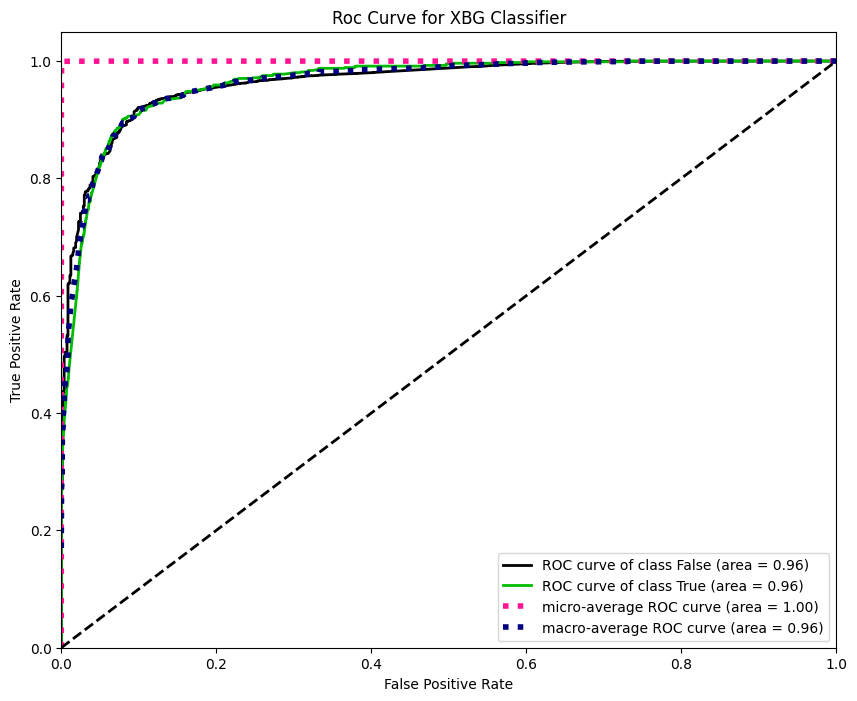

In [25]:
y_probas = xgb_model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, title="Roc Curve for XBG Classifier",figsize=(10, 8))

I trained an Explainable Boosting Machine (EBM) to investigate the boosting properties and the relevance of each sample features. The EBM is also suitable for imbalanced dataset, however, there is no cross-language compatilibity. 

In [22]:
ebm = ExplainableBoostingClassifier(random_state=84)
ebm.fit(X_train, y_train)


ExplainableBoostingClassifier(feature_names=['is_from_official_store',
                                             'is_emulator',
                                             'has_fake_location_app',
                                             'has_fake_location_enabled',
                                             'probable_root', 'device_age_ms',
                                             'max_installations_on_related_devices',
                                             'never_permitted_location_on_account',
                                             'boot_count', 'wallpaper_count',
                                             'n_accounts',
                                             'device_age_ms x n_accounts',
                                             'device_age_ms x '
                                             'never_permitted_l...
                                             'n_accounts',
                                             'device_age_ms x boot_count'],

Save the EBM model

In [23]:
# Save model
with open('/content/drive/MyDrive/incognia/ebm_v1.pkl', 'wb') as file:
  pickle.dump(ebm, file)

Load the EBM model

In [17]:
with open('/content/drive/MyDrive/incognia/ebm_v1.pkl', 'rb') as file:
  ebm = pickle.load(file)
  file.close()



Plot the global summary and the one x one feature importance. This is relevant to understand how the model behave and whats the most relevant features to each class.

In [18]:
ebm_global = ebm.explain_global()
show(ebm_global)

/usr/local/lib/python3.8/dist-packages/interpret/provider/visualize.py:42: UserWarning: Cloud environment detected (['colab', 'ipython']): viz integration is still experimental.
  warn(


I also used the local plot to check the most relevant features given a prediction.

The goal is to find the misclassified cases and check which features are more important to the model. In this case we can inspect the features for false positive or false negative cases.

In [19]:
ebm_local = ebm.explain_local(X_test[:100], y_test[:100])
show(ebm_local)

Here I check and evaluate the results for the EBM.

In [20]:
y_pred_ebm = ebm.predict(X_test)
acc_e = accuracy_score(y_test, y_pred_ebm)
tn_e, fp_e, fn_e, tp_e = confusion_matrix(y_test, y_pred_ebm).ravel()
print('acc - ', acc_e)
print('fp - ', fp_e)
print('fn - ', fn_e)


acc -  0.9992572142489375
fp -  0
fn -  805


The ROC curve for comparison. It achieves a worse performance compared to XGboost, however, there are no false negative cases.

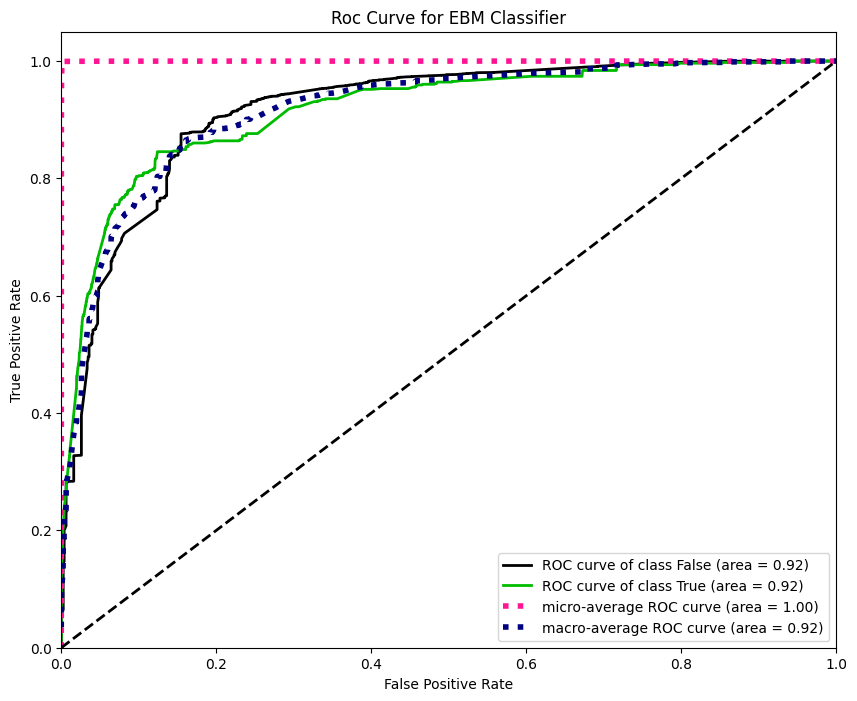

In [21]:
y_probas = ebm.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, title="Roc Curve for EBM Classifier",figsize=(10, 8))

## Final remarks
To decrease the FP rate, I'd consider a ensemble of ensembles in a pipeline form, e.g., XGboost -> Lgbm -> EBM.
With this strategy we can add robustness to dificult decisions, and if the models disagree the EBM can give us a direction on where to look. 

Considering the usage of XGboost only, we can also use a graybox model instead of the glassbox model (EBM) to reach explanability. 

## Production viability analysis
The Xgboost model  did not achieve the desired performance, however, It's suitable for deployment on edge after better parameterization. 

The EBM model is suitable for cloud deploy, as it depends on python and requires more memory than the Xgboost. The benefit is that it didn't present any critical case. 